In [251]:
import numpy as np
from numpy import array, newaxis, expand_dims
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy as copy
import matplotlib.backends.backend_pdf as pdflib
import scipy as sp
import scipy.stats as stats
import math
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_predict
# plotly.tools.set_credentials_file(username='mhossa10', api_key='CSWpOV3xHUVRzimjfHSB')
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [252]:
color_list1 = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02']
color_list2 = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33']
color_list3 = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c']

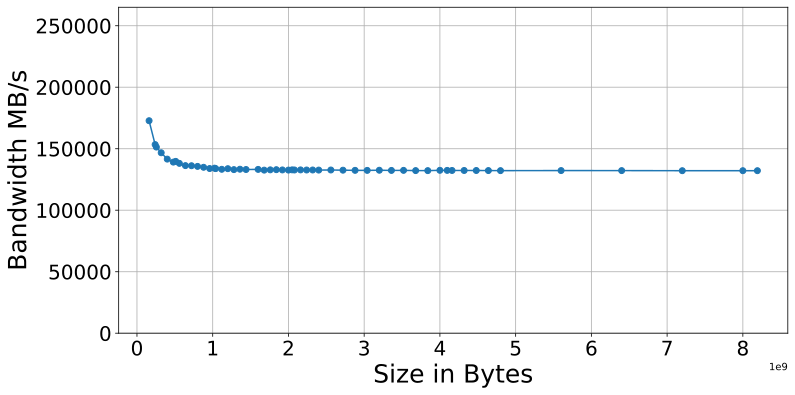

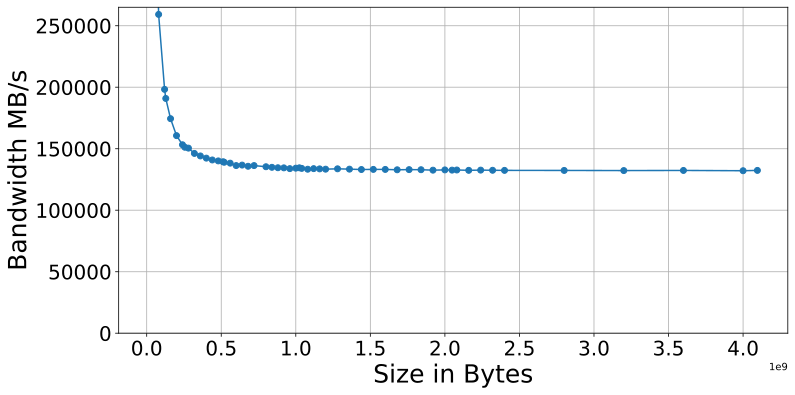

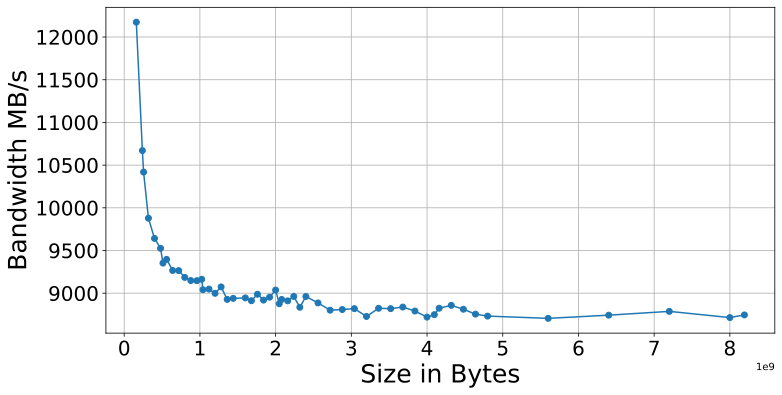

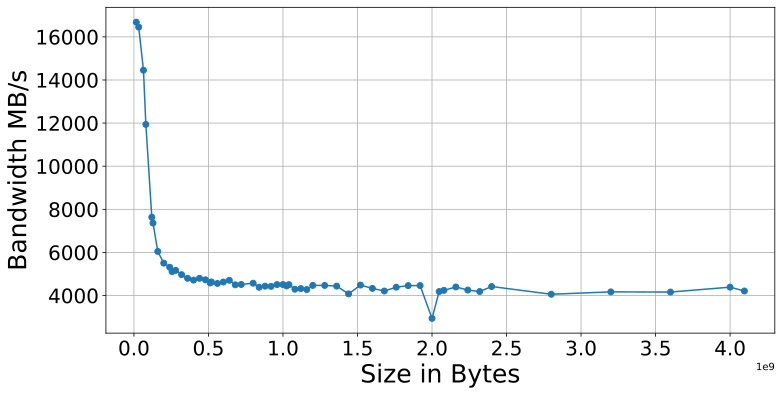

In [253]:
skylake_res = pd.read_csv("../../STREAM/Results/SKYLAKE.csv")
skylake_res = skylake_res[skylake_res["Size"] >= 16000000]
pdf = pdflib.PdfPages("figures/stream/skylake_mpi_copy_double_precision.pdf")
copy_res = skylake_res[(skylake_res["Operation"] == "Copy") & (skylake_res["DataType"] == 8)].sort_values(by="Size").reset_index()
copy_res = copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = copy_res.plot(kind="line", ax=ax1, x="Size", y="Bandwidth_MBS", style="-o", legend=False, figsize=(12,6), fontsize=20)
ax.set_ylabel("Bandwidth MB/s", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()

pdf = pdflib.PdfPages("figures/stream/skylake_mpi_copy_single_precision.pdf")
copy_res = skylake_res[(skylake_res["Operation"] == "Copy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
copy_res = copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = copy_res.plot(kind="line", ax=ax1, x="Size", y="Bandwidth_MBS", style="-o", legend=False, figsize=(12,6), fontsize=20)
ax.set_ylabel("Bandwidth MB/s", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True)
ax.set_ylim(0, 265000)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()



pdf = pdflib.PdfPages("figures/stream/skylake_mpi_random_copy_double_precision.pdf")
random_copy_res = skylake_res[(skylake_res["Operation"] == "RandomCopy") & (skylake_res["DataType"] == 8)].sort_values(by="Size").reset_index()
random_copy_res = random_copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = random_copy_res.plot(kind="line", ax=ax1, x="Size", y="Bandwidth_MBS", style="-o", legend=False, figsize=(12,6), fontsize=20)
ax.set_ylabel("Bandwidth MB/s", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True)
# ax.set_ylim(0, 265000)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()


pdf = pdflib.PdfPages("figures/stream/skylake_mpi_random_copy_single_precision.pdf")
random_copy_res = skylake_res[(skylake_res["Operation"] == "RandomCopy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
random_copy_res = random_copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = random_copy_res.plot(kind="line", ax=ax1, x="Size", y="Bandwidth_MBS", style="-o", legend=False, figsize=(12,6), fontsize=20)
ax.set_ylabel("Bandwidth MB/s", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True)
# ax.set_ylim(0, 265000)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()



# scal_res = skylake_res[(skylake_res["Operation"] == "Scale") & (skylake_res["DataType"] == 8].sort_values(by="Size").reset_index()
# add_res = skylake_res[(skylake_res["Operation"] == "Add") & (skylake_res["DataType"] == 8].sort_values(by="Size").reset_index()
# triad_res = skylake_res[(skylake_res["Operation"] == "Triad") & (skylake_res["DataType"] == 8].sort_values(by="Size").reset_index()


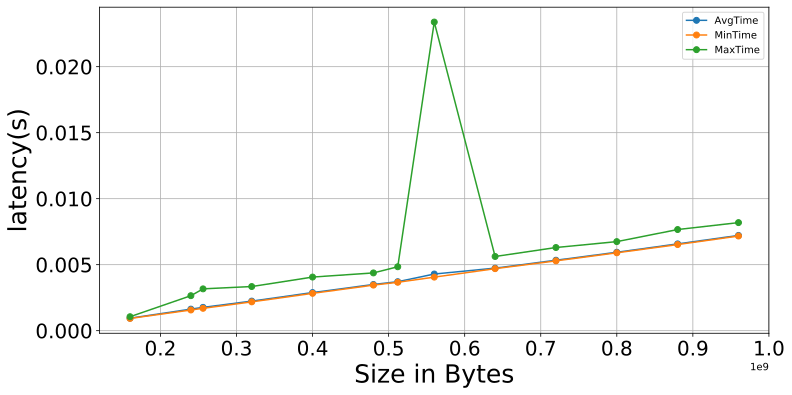

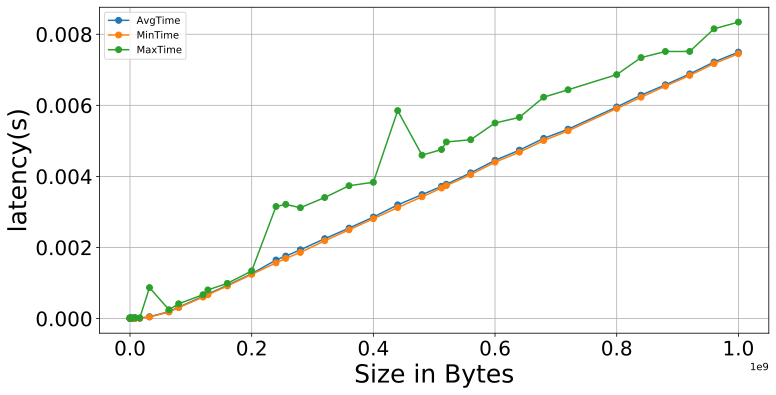

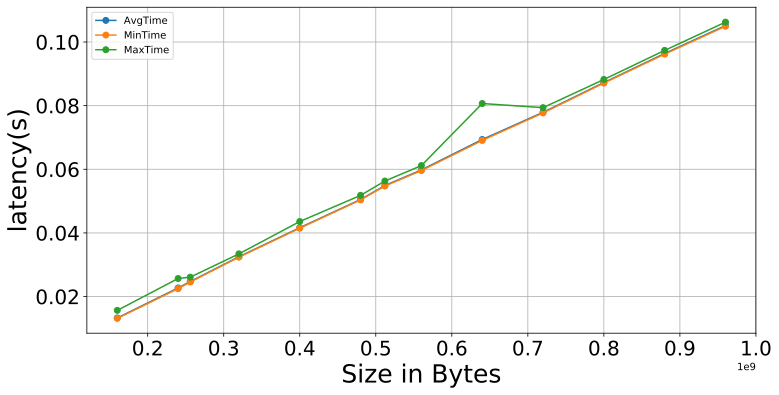

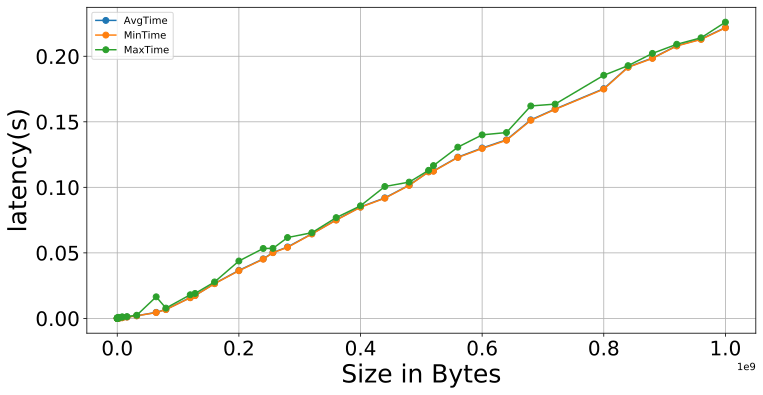

In [254]:
skylake_res = pd.read_csv("../../STREAM/Results/SKYLAKE.csv")
pdf = pdflib.PdfPages("figures/stream/skylake_mpi_copy_double_precision_time.pdf")
copy_res = skylake_res[(skylake_res["Operation"] == "Copy") & (skylake_res["DataType"] == 8)].sort_values(by="Size").reset_index()
copy_res = copy_res[copy_res["Size"] <= 1000000000]
copy_res = copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = copy_res.plot(kind="line", ax=ax1, x="Size", y=["AvgTime", "MinTime", "MaxTime"], style="-o", figsize=(12,6), fontsize=20)
ax.set_ylabel("latency(s)", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
# ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()


pdf = pdflib.PdfPages("figures/stream/skylake_mpi_copy_single_precision_time.pdf")
copy_res = skylake_res[(skylake_res["Operation"] == "Copy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
copy_res = copy_res[copy_res["Size"] <= 1000000000]
copy_res = copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = copy_res.plot(kind="line", ax=ax1, x="Size", y=["AvgTime", "MinTime", "MaxTime"], style="-o", figsize=(12,6), fontsize=20)
ax.set_ylabel("latency(s)", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
# ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()


pdf = pdflib.PdfPages("figures/stream/skylake_mpi_random_copy_double_precision_time.pdf")
random_copy_res = skylake_res[(skylake_res["Operation"] == "RandomCopy") & (skylake_res["DataType"] == 8)].sort_values(by="Size").reset_index()
random_copy_res = random_copy_res[random_copy_res["Size"] <= 1000000000]
random_copy_res = random_copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = random_copy_res.plot(kind="line", ax=ax1, x="Size", y=["AvgTime", "MinTime", "MaxTime"], style="-o", figsize=(12,6), fontsize=20)
ax.set_ylabel("latency(s)", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
# ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()

pdf = pdflib.PdfPages("figures/stream/skylake_mpi_random_copy_single_precision_time.pdf")
random_copy_res = skylake_res[(skylake_res["Operation"] == "RandomCopy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
random_copy_res = random_copy_res[random_copy_res["Size"] <= 1000000000]
random_copy_res = random_copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = random_copy_res.plot(kind="line", ax=ax1, x="Size", y=["AvgTime", "MinTime", "MaxTime"], style="-o", figsize=(12,6), fontsize=20)
ax.set_ylabel("latency(s)", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
# ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()

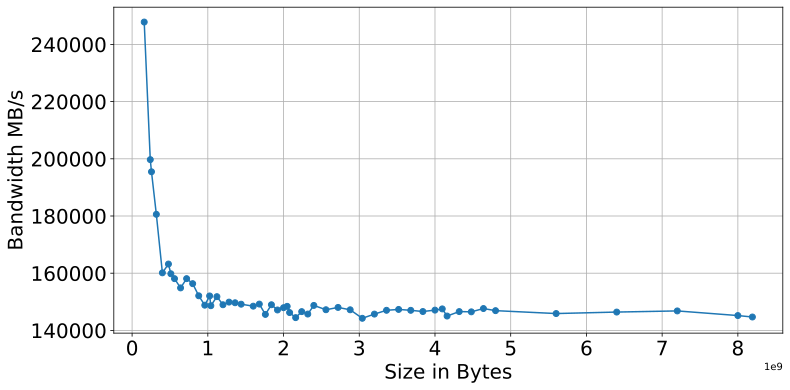

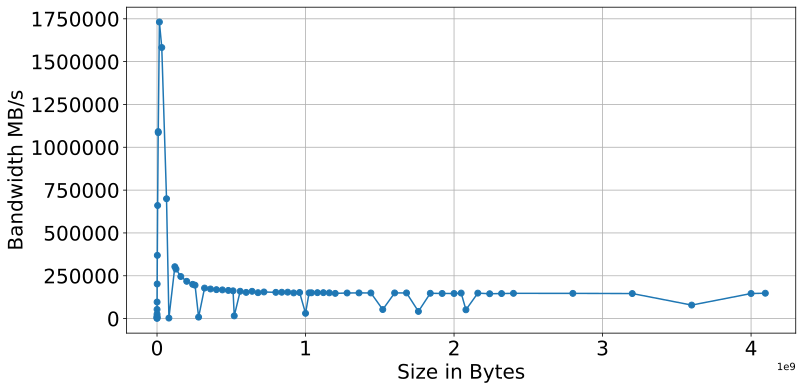

In [255]:
cascade_lake_res = pd.read_csv("../../STREAM/Results/CASCADE_LAKE.csv")
pdf = pdflib.PdfPages("figures/stream/cascade_lake_mpi_copy_double_precision.pdf")
copy_res = cascade_lake_res[(cascade_lake_res["Operation"] == "Copy") & (cascade_lake_res["DataType"] == 8)].sort_values(by="Size").reset_index()
copy_res = copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = copy_res.plot(kind="line", ax=ax1, x="Size", y="Bandwidth_MBS", style="-o", legend=False, figsize=(12,6), fontsize=20)
ax.set_ylabel("Bandwidth MB/s", fontsize=20)
ax.set_xlabel("Size in Bytes", fontsize=20)
ax.grid(True)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()


pdf = pdflib.PdfPages("figures/stream/cascade_lake_mpi_copy_single_precision.pdf")
copy_res = cascade_lake_res[(cascade_lake_res["Operation"] == "Copy") & (cascade_lake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
copy_res = copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = copy_res.plot(kind="line", ax=ax1, x="Size", y="Bandwidth_MBS", style="-o", legend=False, figsize=(12,6), fontsize=20)
ax.set_ylabel("Bandwidth MB/s", fontsize=20)
ax.set_xlabel("Size in Bytes", fontsize=20)
ax.grid(True)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()


# scal_res = cascade_lake_res[(cascade_lake_res["Operation"] == "Scale") & (cascade_lake_res["DataType"] == 8].sort_values(by="Size").reset_index()
# add_res = cascade_lake_res[(cascade_lake_res["Operation"] == "Add") & (cascade_lake_res["DataType"] == 8].sort_values(by="Size").reset_index()
# triad_res = cascade_lake_res[(cascade_lake_res["Operation"] == "Triad") & (cascade_lake_res["DataType"] == 8].sort_values(by="Size").reset_index()


# OSU Benchmark

# Cascade Lake

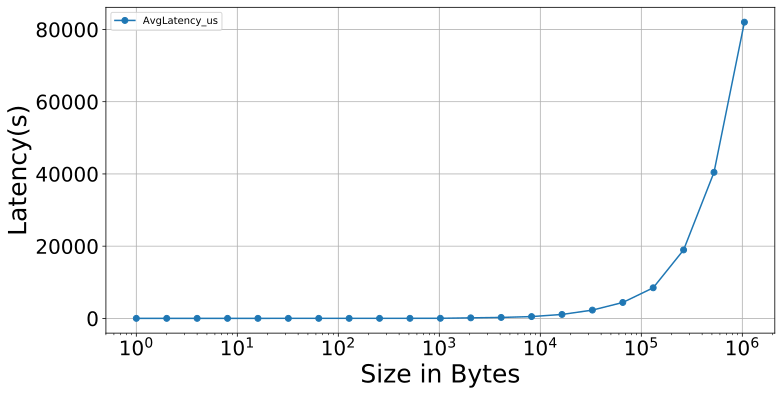

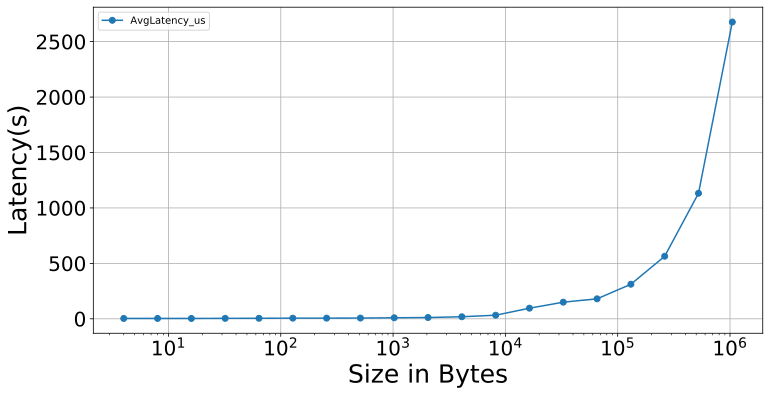

In [256]:
seq_bandwidth = pd.read_csv("../../SpMVMicroBenchmark/mpi/Results/cascade_allgatherv.csv")
seq_bandwidth = seq_bandwidth.groupby("Size").mean().reset_index()

pdf = pdflib.PdfPages("figures/osu/cascade_lake_mpi_allgatherv.pdf")
fig1,ax1 = plt.subplots()
ax = seq_bandwidth.plot(kind="line", ax=ax1, x="Size", y="AvgLatency_us", figsize=(12,6), fontsize=20, style="-o", logx=True)
ax.set_ylabel("Latency(s)", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
# ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()


pdf = pdflib.PdfPages("figures/osu/cascade_lake_mpi_allreduce.pdf")
fig1,ax1 = plt.subplots()
seq_bandwidth = pd.read_csv("../../SpMVMicroBenchmark/mpi/Results/cascade_allreduce.csv")
seq_bandwidth = seq_bandwidth.groupby("Size").mean().reset_index()
ax = seq_bandwidth.plot(kind="line", ax=ax1, x="Size", y="AvgLatency_us", figsize=(12,6), fontsize=20, style="-o", logx=True)
ax.set_ylabel("Latency(s)", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
# ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()

# Skylake

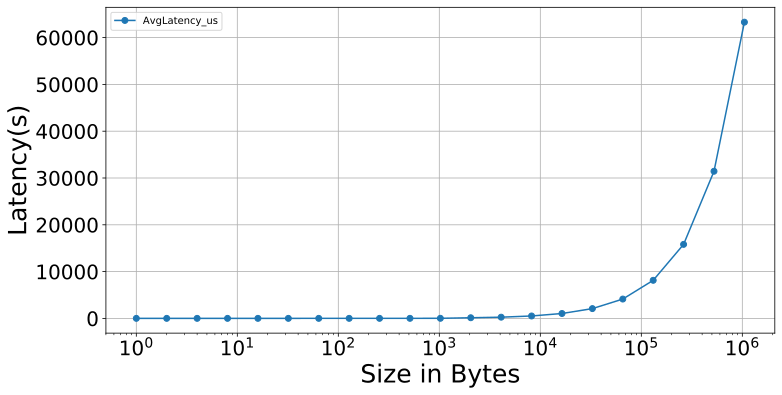

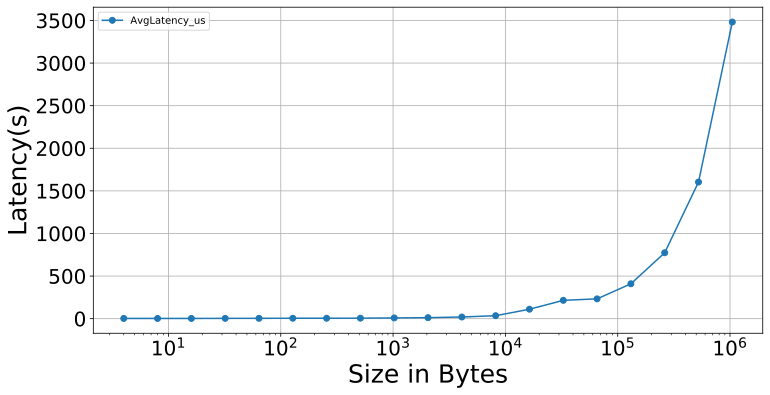

In [257]:
seq_bandwidth = pd.read_csv("../../SpMVMicroBenchmark/mpi/Results/skylake_allgatherv.csv")
seq_bandwidth = seq_bandwidth.groupby("Size").mean().reset_index()

pdf = pdflib.PdfPages("figures/osu/skylake_mpi_allgatherv.pdf")
fig1,ax1 = plt.subplots()
ax = seq_bandwidth.plot(kind="line", ax=ax1, x="Size", y="AvgLatency_us", figsize=(12,6), fontsize=20, style="-o", logx=True)
ax.set_ylabel("Latency(s)", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
# ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()


pdf = pdflib.PdfPages("figures/osu/skylake_mpi_allreduce.pdf")
fig1,ax1 = plt.subplots()
seq_bandwidth = pd.read_csv("../../SpMVMicroBenchmark/mpi/Results/skylake_allreduce.csv")
seq_bandwidth = seq_bandwidth.groupby("Size").mean().reset_index()
ax = seq_bandwidth.plot(kind="line", ax=ax1, x="Size", y="AvgLatency_us", figsize=(12,6), fontsize=20, style="-o", logx=True)
ax.set_ylabel("Latency(s)", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
# ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()

# FMA FLOPS

# MPI

42.83539999999999
85.66865000000001


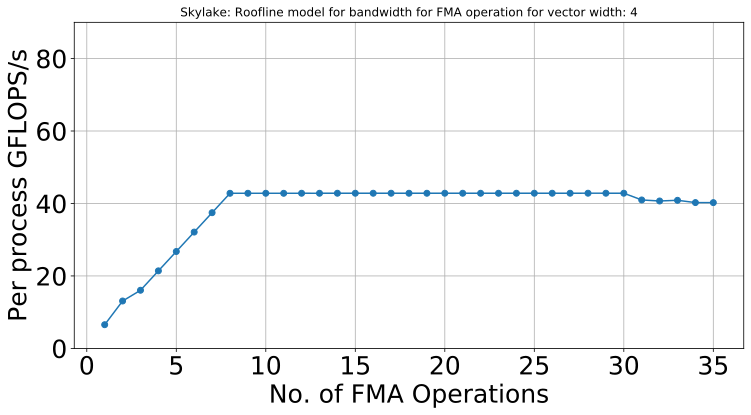

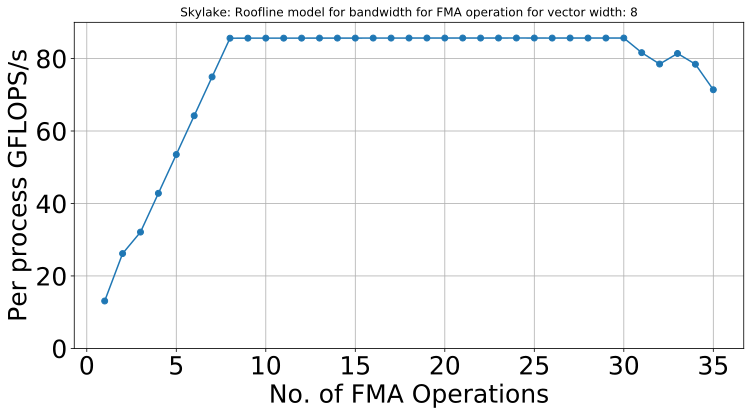

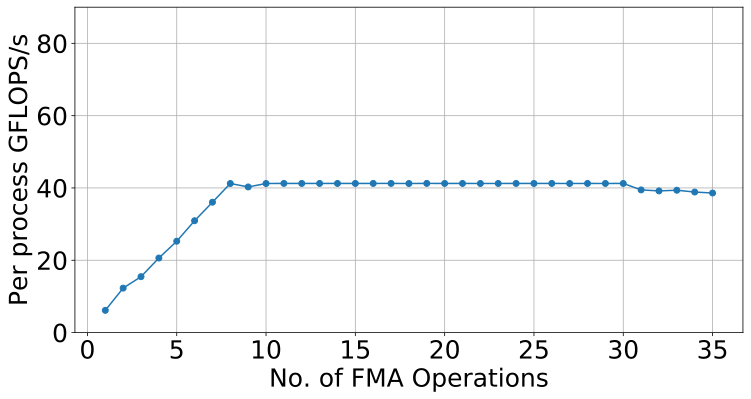

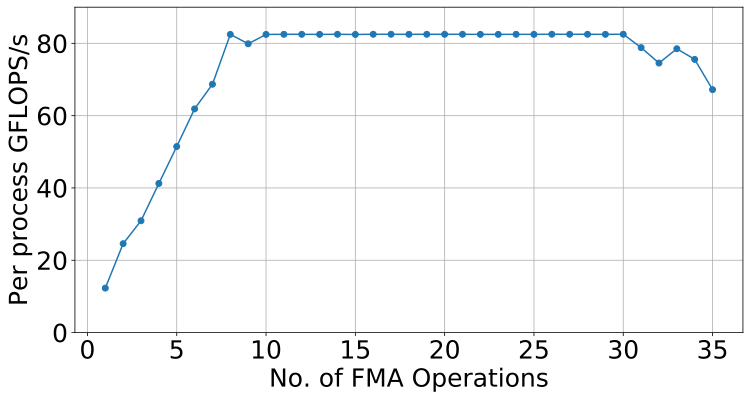

In [258]:
fmaRes = pd.read_csv("../../SpMVMicroBenchmark/mpi/Results/FMA_ON_SKYLAKE.csv")
fmaRes = fmaRes.groupby(["ChainedFMAs", "VectorWidth"]).mean().reset_index()
for vec,vec_data in fmaRes.groupby("VectorWidth"):
    pdf = pdflib.PdfPages("figures/fma/skylake_mpi_fma_roofline_model_for_vec_" + str(vec) + ".pdf")
    fig1,ax1 = plt.subplots()
    vec_data = vec_data.sort_values(by="ChainedFMAs").reset_index(drop=True)
    ax = vec_data.plot(kind="line", style="-o", ax=ax1, x="ChainedFMAs", legend=False, y="AvgGFLOPSPerSec", figsize=(12,6))
    ax.grid(True)
    ax.set_ylim(0,90)
    ax.set_ylabel("Per process GFLOPS/s", fontsize=25)
    ax.set_xlabel("No. of FMA Operations", fontsize=25)
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    ax.set_title("Skylake: Roofline model for bandwidth for FMA operation for vector width: " + str(vec))
    pdf.savefig(fig1, bbox_inches = 'tight')
    pdf.close()
    print(max(vec_data["AvgGFLOPSPerSec"]))
    
fmaRes = pd.read_csv("../../SpMVMicroBenchmark/mpi/Results/FMA_ON_CASCADE_LAKE.csv")
fmaRes = fmaRes.groupby(["ChainedFMAs", "VectorWidth"]).mean().reset_index()
for vec,vec_data in fmaRes.groupby("VectorWidth"):
    pdf = pdflib.PdfPages("figures/fma/cascade_lake_mpi_fma_roofline_model_for_vec_" + str(vec) + ".pdf")
    fig2,ax2 = plt.subplots()
    vec_data = vec_data.sort_values(by="ChainedFMAs").reset_index(drop=True)
    ax = vec_data.plot(kind="line", style="-o", ax=ax2, x="ChainedFMAs", legend=False, y="AvgGFLOPSPerSec", figsize=(12,6))
    ax.grid(True)
    ax.set_ylim(0,90)
    ax.set_ylabel("Per process GFLOPS/s", fontsize=25)
    ax.set_xlabel("No. of FMA Operations", fontsize=25)
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
#     ax.set_title("Cascade Lake: Roofline model for bandwidth for FMA operation for vector width: " + str(vec))
    pdf.savefig(fig2, bbox_inches = 'tight')
    pdf.close()
    
    

# OpenMP

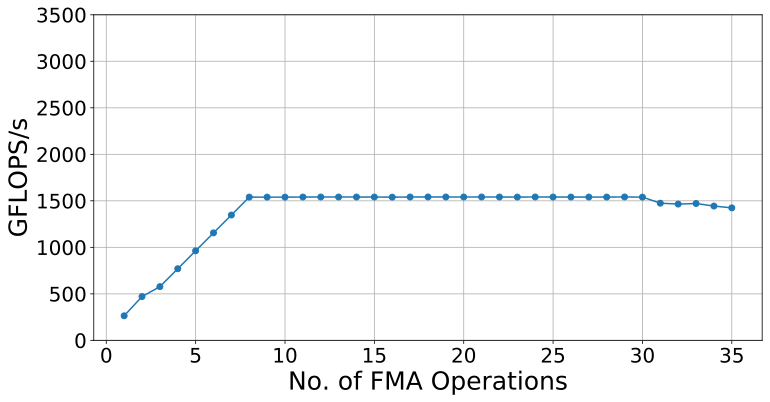

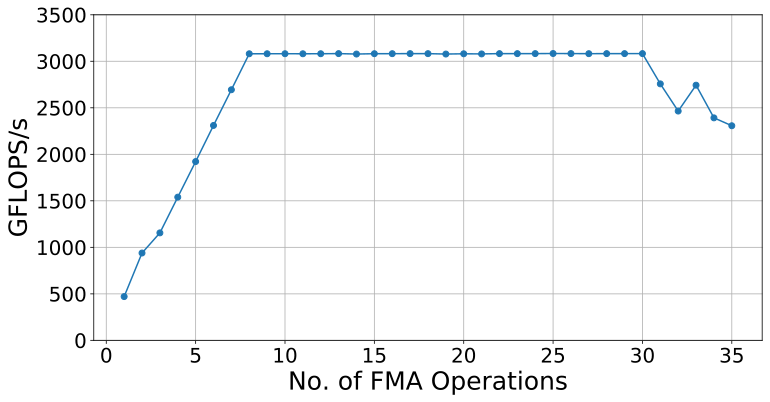

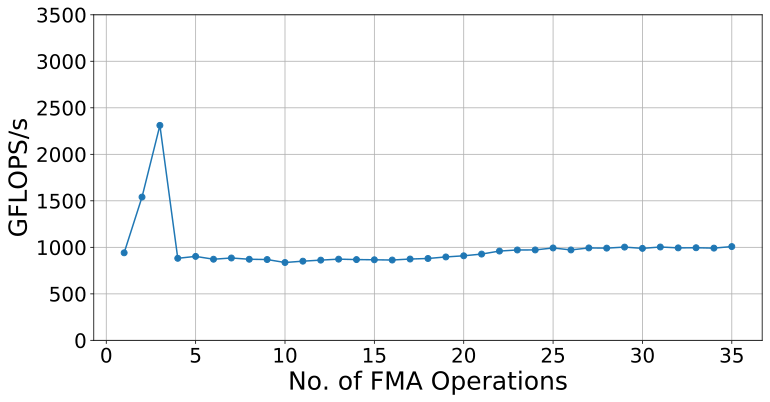

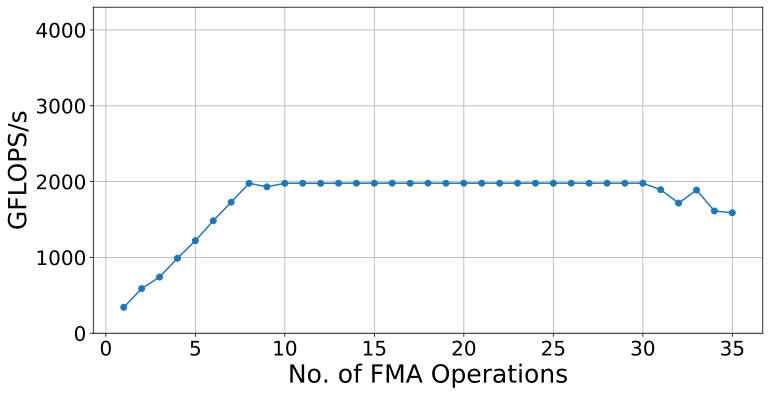

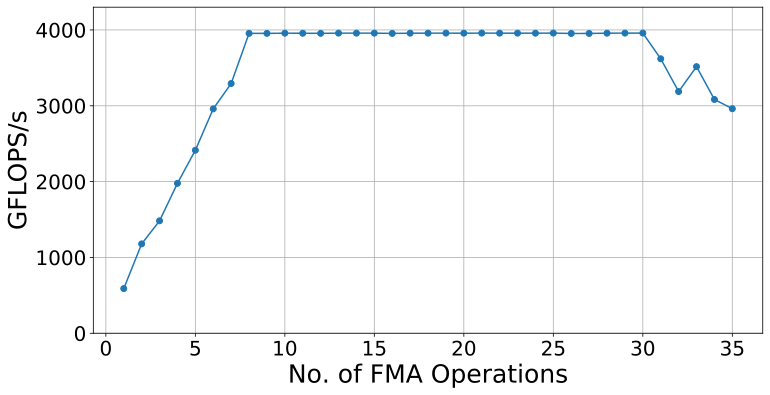

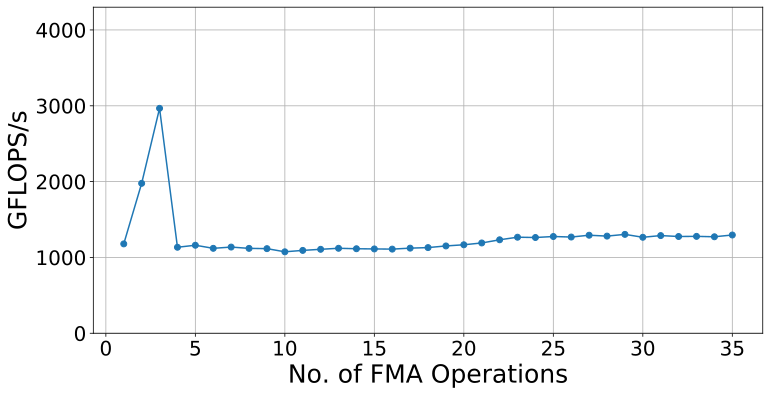

In [259]:
fmaRes = pd.read_csv("../../SpMVMicroBenchmark/omp/Results/FMA_ON_SKYLAKE.csv")
fmaRes = fmaRes.groupby(["ChainedFMAs", "VectorWidth"]).mean().reset_index()

for vec,vec_data in fmaRes.groupby("VectorWidth"):
    pdf = pdflib.PdfPages("figures/fma/skylake_omp_fma_roofline_model_for_vec_" + str(vec) + ".pdf")
    fig1,ax1 = plt.subplots()
    vec_data = vec_data.sort_values(by="ChainedFMAs").reset_index(drop=True)
    ax = vec_data.plot(kind="line", ax=ax1, style="-o", x="ChainedFMAs", legend=False, y="GFLOPSPerSec", figsize=(12,6))
    ax.grid(True)
    ax.set_ylim(0,3500)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_ylabel("GFLOPS/s", fontsize=25)
    ax.set_xlabel("No. of FMA Operations", fontsize=25)
#     ax.set_title("Skylake: Roofline model for bandwidth for FMA operation for vector width: " + str(vec))
    pdf.savefig(fig1, bbox_inches = 'tight')
    pdf.close()

fmaRes = pd.read_csv("../../SpMVMicroBenchmark/omp/Results/FMA_ON_CASCADE_LAKE.csv")
fmaRes = fmaRes.groupby(["ChainedFMAs", "VectorWidth"]).mean().reset_index()
for vec,vec_data in fmaRes.groupby("VectorWidth"):
    pdf = pdflib.PdfPages("figures/fma/cascade_lake_omp_fma_roofline_model_for_vec_" + str(vec) + ".pdf")
    fig2,ax2 = plt.subplots()
    vec_data = vec_data.sort_values(by="ChainedFMAs").reset_index(drop=True)
    ax = vec_data.plot(kind="line", style="-o", ax=ax2, x="ChainedFMAs", legend=False, y="GFLOPSPerSec", figsize=(12,6))
    ax.grid(True)
    ax.set_ylim(0,4300)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_ylabel("GFLOPS/s", fontsize=25)
    ax.set_xlabel("No. of FMA Operations", fontsize=25)
#     ax.set_title("Cascade Lake: Roofline model for bandwidth for FMA operation for vector width: " + str(vec))
    
    pdf.savefig(fig2, bbox_inches = 'tight')
    pdf.close()
    

# Build-Up SpMV Model

In [280]:
test_matrices = [
    "delaunay_n20"
    , "NACA0015"
    , "belgium"
    , "AS365"
    , "roadNet-TX"
    , "road_central"
    , "NLR"
    , "hugetrace-00010"
    , "nlpkkt200"
    , "nlpkkt240"
    , "nlpkkt160"
    , "uk2002"
    , "uk-2002"
]

random_test_matrices = [
    "delaunay_n20_random"
    , "NACA0015_random"
    , "belgium_random"
    , "AS365_random"
    , "roadNet-TX_random"
    , "road_central_random"
    , "NLR_random"
    , "hugetrace-00010_random"
    , "nlpkkt200_random"
    , "nlpkkt240_random"
    , "nlpkkt160_random"
    , "uk2002_random"
    , "uk-2002_random"
]

random_to_org_map = {
    "delaunay_n20_random"      : "delaunay_n20"
    , "NACA0015_random"        : "NACA0015"
    , "belgium_random"         : "belgium"
    , "AS365_random"           : "AS365"
    , "roadNet-TX_random"      : "roadNet-TX"
    , "road_central_random"    : "road_central"
    , "NLR_random"             : "NLR"
    , "hugetrace-00010_random" : "hugetrace-00010"
    , "nlpkkt200_random"       : "nlpkkt200"
    , "nlpkkt240_random"       : "nlpkkt240"
    , "nlpkkt160_random"       : "nlpkkt160"
    , "uk2002_random"          : "uk2002"
    , "uk-2002_random"          : "uk-2002"
}

# Cache Friendliness

In [317]:
cache_data = pd.read_csv("../../ShMemGraph/src/util/Results/CACHE_FRIENDLINESS.csv")
cache_data = cache_data.groupby(["FileName", "Process", "Rank", "DataType", "CacheType", "Architecture"]).mean().reset_index()
kway_cache_data = cache_data[cache_data["FileName"].isin(test_matrices)].reset_index(drop=True)
random_cache_data = cache_data[cache_data["FileName"].isin(random_test_matrices)].reset_index(drop=True)
kway_L3_data = kway_cache_data[(kway_cache_data["CacheType"] == "L3") & (kway_cache_data["Architecture"] == "Skylake")]
rand_L3_data = random_cache_data[(random_cache_data["CacheType"] == "L3") & (random_cache_data["Architecture"] == "Skylake")]

TestMatL3Cache = pd.DataFrame()
_mat = []
_p = []
_miss = []
_hit = []
_rpn = []
_nnnzpn = []
_avg_row = []
_avg_nnz = []
_access = []
for p,p_data in rand_L3_data.groupby(["Process"]):
    for f,data in p_data.groupby(["FileName"]):
        ppn = 36
        data = data.reset_index()
        prcs = p
        node = int(prcs/ppn)
        if len(data) < ppn:
            print("******* ", f, " does not has sufficient data for process: ", p, " *******")
            continue
        _mat.append(random_to_org_map[f])
        _avg_nnz.append(data["NNZ"].mean())
        _avg_row.append(data["Vtx"].mean())
        _p.append(p)
        prcs = ppn*node
        if prcs > len(data):
            print(f, " not fully done! [found", len(data), "of", prcs, "] for process: ", p)
            node = int(len(data)/ppn)
            prcs = node*ppn
            print("Node count: ", node, " process count: ", prcs)
        data = data.iloc[0:prcs]
        nnz = int(data["NNZ"].sum()/node)

        avg_cache_miss = data["CacheMiss"].sum()
        avg_cache_hit = data["CacheHit"].sum()

        avg_cache_miss = avg_cache_miss/node
        avg_cache_hit = avg_cache_hit/node

        _nnnzpn.append(data["NNZ"].sum()/node)
        _rpn.append(data["Vtx"].sum()/node)
        _miss.append(avg_cache_miss)
        _hit.append(avg_cache_hit)
        _access.append(avg_cache_miss + avg_cache_hit)
    
#     print("Node: ", node, " Process: ", prcs)
#     print(f, ": NNZ: ", nnz, " Avg Cache Miss: ", '{:,.3f}'.format(avg_cache_miss), " Avg Cache Hit: ", '{:,.3f}'.format(avg_cache_hit), " Access: ", int(avg_cache_miss+avg_cache_hit))
TestMatL3Cache["Matrices"] = _mat
TestMatL3Cache["Process"] = _p
TestMatL3Cache["AvgRows"] = _avg_row
TestMatL3Cache["AvgNNZ"] = _avg_nnz
TestMatL3Cache["RowsPerNode"] = _rpn
TestMatL3Cache["NNZPerNode"] = _nnnzpn
TestMatL3Cache["CacheMissPerNode"] = _miss
TestMatL3Cache["CacheHitPerNode"] = _hit
TestMatL3Cache["CacheAccessPerNode"] = _access
TestMatL3Cache

nlpkkt240_random  not fully done! [found 88 of 144 ] for process:  144
Node count:  2  process count:  72
uk-2002_random  not fully done! [found 100 of 216 ] for process:  225
Node count:  2  process count:  72
uk-2002_random  not fully done! [found 68 of 252 ] for process:  256
Node count:  1  process count:  36


,Matrices,Process,AvgRows,AvgNNZ,RowsPerNode,NNZPerNode,CacheMissPerNode,CacheHitPerNode,CacheAccessPerNode
0,AS365,144,316607.0,1.578899e+05,11397852.0,5.684038e+06,2.613340e+06,3.070698e+06,5.684038e+06
1,NACA0015,144,86599.0,4.326136e+04,3117564.0,1.557409e+06,1.948182e+05,1.362591e+06,1.557409e+06
2,NLR,144,346981.0,1.734441e+05,12491316.0,6.243988e+06,3.151594e+06,3.092394e+06,6.243988e+06
3,belgium,144,120108.0,2.152736e+04,4323888.0,7.749850e+05,2.564748e+05,5.185102e+05,7.749850e+05
4,delaunay_n20,144,87382.0,4.369008e+04,3145752.0,1.572843e+06,1.965692e+05,1.376274e+06,1.572843e+06
5,hugetrace-00010,144,1004787.0,2.511414e+05,36172332.0,9.041090e+06,7.487958e+06,1.553132e+06,9.041090e+06
6,nlpkkt160,144,695467.0,1.535920e+06,25036812.0,5.529313e+07,4.104062e+07,1.425250e+07,5.529313e+07
7,nlpkkt200,144,1353334.0,2.999900e+06,48720024.0,1.079964e+08,9.366272e+07,1.433369e+07,1.079964e+08
8,nlpkkt240,144,2332800.0,5.183890e+06,83980800.0,1.866206e+08,1.722481e+08,1.437244e+07,1.866206e+08
9,roadNet-TX,144,114994.0,2.668972e+04,4139784.0,9.608300e+05,2.530208e+05,7.078092e+05,9.608300e+05


In [349]:
csr_2d_spmv = pd.read_csv("../../SpMV_Model/src/SkylakeResults/MPI_CSR_2D_SpMV.csv")
csr_2d_spmv = csr_2d_spmv[~csr_2d_spmv['Name'].str.contains("rmat")].reset_index(drop=True)
csr_2d_ref = csr_2d_spmv[["Name", "Nodes", "nProcess", "DataType", "AvgRow", "NNZ", "NonZeroPerRow", "AvgNPRSD", "AvgTime", "AvgBcastTime", "AvgMatmulTime"]]
csr_2d_ref = csr_2d_ref.groupby(["Name", "Nodes", "nProcess", "DataType"]).mean().reset_index().sort_values(by=["Name", "Nodes", "nProcess", "DataType"]).reset_index(drop=True)
csr_2d_test = pd.DataFrame()
csr_2d_test["Name"] = csr_2d_ref["Name"]
csr_2d_test["Nodes"] = csr_2d_ref["Nodes"]
csr_2d_test["nProcess"] = csr_2d_ref["nProcess"]
csr_2d_test["AvgRow"] = csr_2d_ref["AvgRow"]
csr_2d_test["NNZ"] = csr_2d_ref["NNZ"]
csr_2d_test["AvgTime"] = csr_2d_ref["AvgTime"]/1000
csr_2d_test["AvgBcastTime"] = csr_2d_ref["AvgBcastTime"]/1000
csr_2d_test["AvgMatmulTime"] = csr_2d_ref["AvgMatmulTime"]/1000
csr_2d_test["Size"] = 36*((12*csr_2d_ref["AvgRow"]) + (8*csr_2d_ref["NNZ"])) 
csr_2d_test = csr_2d_test[csr_2d_test["Size"] >= 100000000].reset_index(drop=True).sort_values(by="AvgRow").reset_index(drop=True)
VEC_WIDTH = 4
FLOPS_PER_CAL = 2
FLOP_PER_SEC = 42.84
csr_2d_test["TimeForFLOPS"] = (1.0e-9 * csr_2d_test["NNZ"] * VEC_WIDTH * FLOPS_PER_CAL)/FLOP_PER_SEC
csr_2d_test = csr_2d_test[csr_2d_test["Name"].isin(test_matrices)].reset_index(drop=True)

_miss = []
_hit = []
_access = []

for i,r in csr_2d_test.iterrows():
    cache_data = TestMatL3Cache[(TestMatL3Cache["Matrices"] == r["Name"]) & (TestMatL3Cache["Process"] == r["nProcess"])].reset_index(drop=True)
    _miss.append(cache_data["CacheMissPerNode"].iloc[0]*4)
    _hit.append(cache_data["CacheHitPerNode"].iloc[0]*4)
    _access.append(cache_data["CacheAccessPerNode"].iloc[0]*4)
csr_2d_test["CacheMissPerNode"] = _miss
csr_2d_test["CacheHitPerNode"] = _hit
csr_2d_test["CacheAccessPerNode"] = _access
#CacheMissPerNode CacheHitPerNode CacheAccessPerNode
# for f,g_data in csr_2d_test.groupby("Name"):
#     print(f)
#     for p,p_data in g_data.groupby("nProcess"):
#         print(p, end=" ")
#     print()
# print("************ Cache Info *************")
# for f,g_data in TestMatL3Cache.groupby("Matrices"):
#     print(f)
#     for p,p_data in g_data.groupby("Process"):
#         print(p, end=" ")
#     print()

csr_2d_test["SeqSize"] = csr_2d_test["Size"] + csr_2d_test["CacheHitPerNode"]
csr_2d_test["RandomSize"] = csr_2d_test["CacheMissPerNode"]
csr_2d_test

,Name,Nodes,nProcess,AvgRow,NNZ,AvgTime,AvgBcastTime,AvgMatmulTime,Size,TimeForFLOPS,CacheMissPerNode,CacheHitPerNode,CacheAccessPerNode,SeqSize,RandomSize
0,AS365,8,256,237455,88813,0.004371,0.001043,0.001738,128158704,0.000017,4.006044e+06,8.783337e+06,1.278938e+07,1.369420e+08,4.006044e+06
1,AS365,7,225,253285,101049,0.004683,0.001113,0.001949,138521232,0.000019,5.046069e+06,9.504933e+06,1.455100e+07,1.480262e+08,5.046069e+06
2,NLR,8,256,260236,97562,0.004813,0.001150,0.001960,140519808,0.000018,5.134838e+06,8.913890e+06,1.404873e+07,1.494337e+08,5.134838e+06
3,NLR,7,225,277585,111004,0.005410,0.001224,0.002416,151885872,0.000021,6.361668e+06,9.623634e+06,1.598530e+07,1.615095e+08,6.361668e+06
4,AS365,5,169,292252,134533,0.005843,0.001162,0.002832,164998368,0.000025,8.143538e+06,1.123022e+07,1.937376e+07,1.762286e+08,8.143538e+06
5,AS365,4,144,316607,157889,0.007409,0.001752,0.003285,182246256,0.000029,1.045336e+07,1.228279e+07,2.273615e+07,1.945290e+08,1.045336e+07
6,NLR,5,169,320290,147786,0.006484,0.001282,0.003184,180927648,0.000028,9.951472e+06,1.133025e+07,2.128172e+07,1.922579e+08,9.951472e+06
7,NLR,4,144,346981,173444,0.008224,0.001924,0.003674,199847664,0.000032,1.260638e+07,1.236958e+07,2.497595e+07,2.122172e+08,1.260638e+07
8,nlpkkt160,8,256,521600,863955,0.018582,0.002348,0.012869,474150240,0.000161,8.180384e+07,4.260587e+07,1.244097e+08,5.167561e+08,8.180384e+07
9,nlpkkt160,7,225,556374,982988,0.022838,0.002507,0.015164,523454112,0.000184,9.606296e+07,4.548930e+07,1.415523e+08,5.689434e+08,9.606296e+07


In [482]:
random_bandwidth = dp_random_copy["Bandwidth_MBS"].mean() * 1.0E06
random_bandwidth
csr_2d_test["RandomLatency"] = csr_2d_test["RandomSize"] /(random_bandwidth)

In [368]:
min(csr_2d_test["RandomSize"])

4006044.0

# Memory Access Model on Skylake(Single Precision)

In [364]:
skylake_res = pd.read_csv("../../STREAM/Results/SKYLAKE.csv")
skylake_res = skylake_res[skylake_res["Size"] >= 100000000]
##### Sequential Access #####
dp_copy = skylake_res[(skylake_res["Operation"] == "Copy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
dp_copy = dp_copy.groupby("Size").mean().reset_index().sort_values(by="Size").reset_index()


min_time_factor = 1.0
if min(dp_copy["AvgTime"]) < 1.0:
    min_time_factor = 1/min(dp_copy["AvgTime"])
for i,r in dp_copy.iterrows():
    dp_copy.at[i, "AvgTime"] = min_time_factor*r["AvgTime"]
# for i,r in csr_2d_test.iterrows():
#     csr_2d_test.at[i, "AvgMatmulTime"] = min_time_factor*r["AvgMatmulTime"]
    
train_x = dp_copy[["Size"]].to_numpy()
test_x = csr_2d_test[["SeqSize"]].to_numpy()
csr_2d_X = np.concatenate((train_x, test_x), axis=0)
scaler = MinMaxScaler()  # Default behavior is to scale to [0,1]
csr_2d_X = scaler.fit_transform(csr_2d_X)
X = csr_2d_X[0:len(train_x)]
test_X = csr_2d_X[len(train_x):]
train_y = np.array(dp_copy["AvgTime"])
test_y = np.array(csr_2d_test["AvgMatmulTime"])
        
scores = []
best = 0
# c=20e4
# e=0.001
for c in np.linspace(2e1,6e4, num=50):
    for e in np.linspace(0.0001, 0.9, 20):
        best_svr = SVR(kernel='poly', C=c, gamma='auto', degree=3, epsilon=e, coef0=1)
        cv = KFold(n_splits=5, random_state=42, shuffle=True)
        for train_index, test_index in cv.split(X):
            X_train, X_test, y_train, y_test = X[train_index], X[test_index], train_y[train_index], train_y[test_index]
            best_svr.fit(X_train, y_train)
            scores.append(best_svr.score(X_test, np.array(y_test)))
            if best < np.mean(scores):
                best = np.mean(scores)
                best_param = {"C": c, "epsilon": e}
svr1 = SVR(kernel='poly', C=best_param['C'], gamma='auto', degree=3, epsilon=best_param['epsilon'], coef0=1)
svr1.fit(X, train_y)






SVR(C=60000.0, cache_size=200, coef0=1, degree=3, epsilon=0.9, gamma='auto',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [484]:
y_pred = svr1.predict(test_X)
# rn_y_pred = y_svr

_pred = pd.DataFrame()
mat = [] 
node = []
prcs = []
rows = []
nnz_r = []
a_time = []
p_time = []
time_for_flops = []
err = []
_model = []
m_size = []
max_err = 0
avg_err = 0
for i,row in csr_2d_test.iterrows():
#     print(y[index])
#     g = row["Name"].split("_")
    dp_pred = (y_pred[i]/min_time_factor) + row["TimeForFLOPS"] + row["RandomLatency"] #(rn_y_pred[i]/random_min_time_factor)
    print(row["Name"], row["AvgRow"], row["Nodes"], row["nProcess"], row["Size"], '{0:.5g}'.format(test_y[i]),"&",'{0:.5g}'.format(dp_pred), "&", 
          '{0:.4g}'.format(abs(test_y[i]-dp_pred)*100/test_y[i])+"\\%", "\\\ \hline")           
    if max_err < abs(test_y[i]-dp_pred)*100/test_y[i]:
        max_err = abs(test_y[i]-dp_pred)*100/test_y[i]
    avg_err += abs(test_y[i]-dp_pred)*100/test_y[i]
    rows.append(row["Size"])
    a_time.append(float('{0:.5g}'.format(test_y[i])))
    p_time.append(float('{0:.5g}'.format(dp_pred)))
    err.append(float('{0:.4g}'.format(abs(test_y[i]-dp_pred)*100/test_y[i])))
    mat.append(row["Name"])
    node.append(row["Nodes"])
    prcs.append(row["nProcess"])
    _model.append("Single Precision")
    time_for_flops.append(row["TimeForFLOPS"])
# omp_data.groupby("Threads").count()
print("best param: ", best_param)
print("max error: ", max_err, " avg error: ", avg_err/csr_2d_test.shape[0])

_pred["Matrices"] = mat
_pred["Nodes"] = node
_pred["nProcess"] = prcs
_pred["Sizes"] = rows
_pred["Model"] = _model
_pred["TimeForFLOPS"] = time_for_flops
_pred["Actual Time"] = a_time
_pred["Predicted Time"] = p_time
_pred["Error"] = err

AS365 237455 8 256 128158704 0.001738 & 0.0018004 & 3.592\% \\ \hline
AS365 253285 7 225 138521232 0.0019494 & 0.0021311 & 9.32\% \\ \hline
NLR 260236 8 256 140519808 0.0019603 & 0.002162 & 10.29\% \\ \hline
NLR 277585 7 225 151885872 0.0024159 & 0.0025443 & 5.314\% \\ \hline
AS365 292252 5 169 164998368 0.0028317 & 0.0030785 & 8.716\% \\ \hline
AS365 316607 4 144 182246256 0.0032855 & 0.0037637 & 14.55\% \\ \hline
NLR 320290 5 169 180927648 0.0031836 & 0.003627 & 13.93\% \\ \hline
NLR 346981 4 144 199847664 0.0036744 & 0.004406 & 19.91\% \\ \hline
nlpkkt160 521600 8 256 474150240 0.012869 & 0.023054 & 79.14\% \\ \hline
nlpkkt160 556374 7 225 523454112 0.015164 & 0.026811 & 76.81\% \\ \hline
nlpkkt160 641970 5 169 654240384 0.018174 & 0.037239 & 104.9\% \\ \hline
nlpkkt160 695467 4 144 742786704 0.02137 & 0.044609 & 108.7\% \\ \hline
hugetrace-00010 753591 8 256 366236208 0.0056292 & 0.0063608 & 13\% \\ \hline
hugetrace-00010 803830 7 225 393544800 0.0071019 & 0.007155 & 0.7472\% \\ \h

In [485]:
_pred = _pred.sort_values(by=["Matrices", "Nodes"]).reset_index(drop=True)
data = _pred[_pred["Matrices"].isin(test_matrices)].reset_index(drop=True)
for i,r in data.iterrows():
    print(r["Matrices"], "&", r["Nodes"], "&", r["nProcess"], "&", '{:,.3f}'.format(r["Actual Time"]*1000), "&", '{:,.3f}'.format(r["Predicted Time"]*1000), "&", str(r["Error"])+"\\%", "\\\\ \hline")

AS365 & 4 & 144 & 3.285 & 3.764 & 14.55\% \\ \hline
AS365 & 5 & 169 & 2.832 & 3.079 & 8.716\% \\ \hline
AS365 & 7 & 225 & 1.949 & 2.131 & 9.32\% \\ \hline
AS365 & 8 & 256 & 1.738 & 1.800 & 3.592\% \\ \hline
NLR & 4 & 144 & 3.674 & 4.406 & 19.91\% \\ \hline
NLR & 5 & 169 & 3.184 & 3.627 & 13.93\% \\ \hline
NLR & 7 & 225 & 2.416 & 2.544 & 5.314\% \\ \hline
NLR & 8 & 256 & 1.960 & 2.162 & 10.29\% \\ \hline
hugetrace-00010 & 4 & 144 & 9.267 & 10.787 & 16.4\% \\ \hline
hugetrace-00010 & 5 & 169 & 9.069 & 9.303 & 2.582\% \\ \hline
hugetrace-00010 & 7 & 225 & 7.102 & 7.155 & 0.7472\% \\ \hline
hugetrace-00010 & 8 & 256 & 5.629 & 6.361 & 13.0\% \\ \hline
nlpkkt160 & 4 & 144 & 21.370 & 44.609 & 108.7\% \\ \hline
nlpkkt160 & 5 & 169 & 18.174 & 37.239 & 104.9\% \\ \hline
nlpkkt160 & 7 & 225 & 15.164 & 26.811 & 76.81\% \\ \hline
nlpkkt160 & 8 & 256 & 12.869 & 23.054 & 79.14\% \\ \hline
nlpkkt200 & 4 & 144 & 54.002 & 99.510 & 84.27\% \\ \hline
nlpkkt200 & 5 & 169 & 46.353 & 84.164 & 81.57\% \\ \hli

In [367]:
rn_y_pred

array([-4.85079129e+01, -8.15314784e+00, -4.70847883e+00,  4.29022317e+01,
        1.12066455e+02,  2.01747369e+02,  1.82258764e+02,  2.85364297e+02,
        2.98515542e+03,  3.54443541e+03,  5.11125516e+03,  6.22913356e+03,
        4.08362233e+02,  5.04431265e+02,  3.93357664e+02,  7.71018772e+02,
        4.84866686e+02,  9.59863695e+02,  7.65367839e+03,  8.87229914e+03,
        7.38494431e+02,  9.17999285e+02,  1.22607776e+04,  1.46650699e+04,
        1.47523699e+04,  1.69889552e+04,  2.32082735e+04,  2.76227159e+04])

In [266]:
'{:,.2f}'.format(max(dp_copy["Size"]))

'4,096,000,000.00'

In [267]:
'{:,.2f}'.format(max(_pred["Sizes"]))

'3,247,205,760.00'

In [268]:
csr_gk_spmv = pd.read_csv("../../SpMV_Model/src/SkylakeResults/MPI_KWAY_SpMV.csv")
csr_gk_spmv = csr_gk_spmv[~csr_gk_spmv['Name'].str.contains("rmat")].reset_index(drop=True)
csr_gk_ref = csr_gk_spmv[["Name", "Nodes", "nProcess", "DataType", "AvgRows", "AvgNNZ", "AvgNPR", "AvgNPRSD", "AvgTime", "AvgGatherTime", "AvgMatmulTime"]]
csr_gk_ref = csr_gk_ref.groupby(["Name", "Nodes", "nProcess", "DataType"]).mean().reset_index().sort_values(by=["Name", "Nodes", "nProcess", "DataType"]).reset_index(drop=True)
csr_gk_test = pd.DataFrame()
csr_gk_test["Name"] = csr_gk_ref["Name"]
csr_gk_test["Nodes"] = csr_gk_ref["Nodes"]
csr_gk_test["nProcess"] = csr_gk_ref["nProcess"]
csr_gk_test["AvgRow"] = csr_gk_ref["AvgRows"]
csr_gk_test["NNZ"] = csr_gk_ref["AvgNNZ"]
csr_gk_test["Size"] = 36*((12*csr_gk_ref["AvgRows"]) + (12*csr_gk_ref["AvgNNZ"]))
csr_gk_test["RandomSize"] = 36*(4*csr_gk_ref["AvgNNZ"])
csr_gk_test["AvgTime"] = csr_gk_ref["AvgTime"]/1000
csr_gk_test["AvgGatherTime"] = csr_gk_ref["AvgGatherTime"]/1000
csr_gk_test["AvgMatmulTime"] = csr_gk_ref["AvgMatmulTime"]/1000
csr_gk_test = csr_gk_test[csr_gk_test["Size"] >= 100000000].reset_index(drop=True).sort_values(by="AvgRow").reset_index(drop=True)
VEC_WIDTH = 4
FLOPS_PER_CAL = 2
FLOP_PER_SEC = 42.84
csr_gk_test["TimeForFLOPS"] = (1.0e-9 * csr_2d_test["NNZ"] * VEC_WIDTH * FLOPS_PER_CAL)/FLOP_PER_SEC
csr_gk_test

,Name,Nodes,nProcess,AvgRow,NNZ,Size,RandomSize,AvgTime,AvgGatherTime,AvgMatmulTime,TimeForFLOPS
0,audikw1,8,256,3686,299641,131037264,43148304,0.006514,0.006021,0.000493,0.000042
1,audikw1,7,225,4194,340925,149091408,49093200,0.006515,0.005939,0.000576,0.000040
2,audikw1,5,169,5583,453894,198494064,65360736,0.007008,0.006225,0.000783,0.000056
3,ldoor,5,169,5634,269646,118920960,38829024,0.005467,0.004975,0.000492,0.000033
4,audikw1,4,144,6553,532695,232955136,76708080,0.007900,0.006953,0.000948,0.000064
...,...,...,...,...,...,...,...,...,...,...,...
65,nlpkkt240,4,144,194400,5183880,2323416960,746478720,0.198440,0.189729,0.008711,0.000019
66,europe,8,256,198875,422302,268348464,60811488,0.309565,0.307788,0.001777,0.000018
67,europe,7,225,226275,480485,305320320,69189840,0.295980,0.293654,0.002326,0.000012
68,europe,5,169,301254,639700,406492128,92116800,0.318403,0.315079,0.003324,0.000023


In [269]:
skylake_res = pd.read_csv("../../STREAM/Results/SKYLAKE.csv")
skylake_res = skylake_res[skylake_res["Size"] >= 100000000]
##### Sequential Access #####
dp_copy = skylake_res[(skylake_res["Operation"] == "Copy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
dp_copy = dp_copy.groupby("Size").mean().reset_index().sort_values(by="Size").reset_index()


min_time_factor = 1.0
if min(dp_copy["AvgTime"]) < 1.0:
    min_time_factor = 1/min(dp_copy["AvgTime"])
for i,r in dp_copy.iterrows():
    dp_copy.at[i, "AvgTime"] = min_time_factor*r["AvgTime"]
# for i,r in csr_2d_test.iterrows():
#     csr_2d_test.at[i, "AvgMatmulTime"] = min_time_factor*r["AvgMatmulTime"]
    
train_x = dp_copy[["Size"]].to_numpy()
test_x = csr_gk_test[["Size"]].to_numpy()
csr_gk_X = np.concatenate((train_x, test_x), axis=0)
scaler = MinMaxScaler()  # Default behavior is to scale to [0,1]
csr_gk_X = scaler.fit_transform(csr_gk_X)
X = csr_gk_X[0:len(train_x)]
test_X = csr_gk_X[len(train_x):]
train_y = np.array(dp_copy["AvgTime"])
test_y = np.array(csr_gk_test["AvgMatmulTime"])
        
scores = []
best = 0
# c=20e4
# e=0.001
for c in np.linspace(2e1,6e4, num=50):
    for e in np.linspace(0.0001, 0.9, 20):
        best_svr = SVR(kernel='poly', C=c, gamma='auto', degree=3, epsilon=e, coef0=1)
        cv = KFold(n_splits=5, random_state=42, shuffle=True)
        for train_index, test_index in cv.split(X):
            X_train, X_test, y_train, y_test = X[train_index], X[test_index], train_y[train_index], train_y[test_index]
            best_svr.fit(X_train, y_train)
            scores.append(best_svr.score(X_test, np.array(y_test)))
            if best < np.mean(scores):
                best = np.mean(scores)
                best_param = {"C": c, "epsilon": e}
svr1 = SVR(kernel='poly', C=best_param['C'], gamma='auto', degree=3, epsilon=best_param['epsilon'], coef0=1)
svr1.fit(X, train_y)


#### Random Access ####
# dp_random_copy = skylake_res[(skylake_res["Operation"] == "RandomCopy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
# dp_random_copy = dp_random_copy.groupby("Size").mean().reset_index().sort_values(by="Size").reset_index()

# random_min_time_factor = 1.0
# if min(dp_random_copy["AvgTime"]) < 1.0:
#     random_min_time_factor = 1/min(dp_random_copy["AvgTime"])
# for i,r in dp_random_copy.iterrows():
#     dp_random_copy.at[i, "AvgTime"] = random_min_time_factor*r["AvgTime"]
    
# rn_train_x = dp_random_copy[["Size"]].to_numpy()
# rn_test_x = csr_2d_test[["RandomSize"]].to_numpy()
# rn_csr_2d_X = np.concatenate((rn_train_x, rn_test_x), axis=0)
# scaler = MinMaxScaler()  # Default behavior is to scale to [0,1]
# rn_csr_2d_X = scaler.fit_transform(rn_csr_2d_X)
# rn_X = rn_csr_2d_X[0:len(rn_train_x)]
# rn_test_X = rn_csr_2d_X[len(rn_train_x):]
# rn_train_y = np.array(dp_random_copy["AvgTime"])
        
# scores = []
# best = 0
# # c=20e4
# # e=0.001
# for c in np.linspace(2e1,6e4, num=50):
#     for e in np.linspace(0.0001, 0.9, 20):
#         best_svr = SVR(kernel='poly', C=c, gamma='auto', degree=3, epsilon=e, coef0=1)
#         cv = KFold(n_splits=5, random_state=42, shuffle=True)
#         for train_index, test_index in cv.split(rn_X):
#             X_train, X_test, y_train, y_test = rn_X[train_index], rn_X[test_index], rn_train_y[train_index], rn_train_y[test_index]
#             best_svr.fit(X_train, y_train)
#             scores.append(best_svr.score(X_test, np.array(y_test)))
#             if best < np.mean(scores):
#                 best = np.mean(scores)
#                 best_param = {"C": c, "epsilon": e}
# svr2 = SVR(kernel='poly', C=best_param['C'], gamma='auto', degree=3, epsilon=best_param['epsilon'], coef0=1)
# svr2.fit(rn_X, rn_train_y)



SVR(C=20.0, cache_size=200, coef0=1, degree=3, epsilon=0.0001, gamma='auto',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [461]:
dp_random_copy

,level_0,Size,index,Bandwidth_MBS,AvgTime,MinTime,MaxTime,DataType
0,0,8.000000e+03,912,1675.195,0.000005,0.000005,0.000017,4
1,1,1.600000e+04,916,3073.855,0.000006,0.000005,0.000009,4
2,2,3.200000e+04,920,5172.975,0.000007,0.000006,0.000014,4
3,3,6.400000e+04,924,7781.190,0.000014,0.000008,0.000521,4
4,4,1.280000e+05,930,9137.270,0.000015,0.000014,0.000028,4
...,...,...,...,...,...,...,...,...
66,66,2.800000e+09,500,4060.850,0.690223,0.689511,0.691484,4
67,67,3.200000e+09,504,4171.120,0.767896,0.767179,0.769383,4
68,68,3.600000e+09,516,4162.130,0.865474,0.864941,0.867091,4
69,69,4.000000e+09,540,4388.860,0.911789,0.911398,0.918879,4


4278047678.5714293

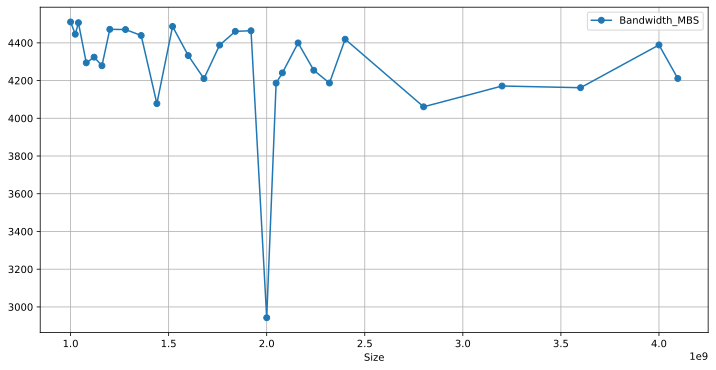

In [480]:
skylake_res = pd.read_csv("../../STREAM/Results/SKYLAKE.csv")
dp_random_copy = skylake_res[(skylake_res["Operation"] == "RandomCopy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
dp_random_copy = dp_random_copy[dp_random_copy["Size"] >= 1000000000]
dp_random_copy = dp_random_copy.groupby("Size").mean().reset_index().sort_values(by="Size").reset_index()
ax = dp_random_copy[dp_random_copy["Size"] >= 1000000000].plot(kind="line", x="Size", style="-o", y="Bandwidth_MBS", figsize=(12,6))
ax.grid()
csr_2d_test["RandomSize"]


In [270]:
y_pred = svr1.predict(test_X)
# rn_y_pred = svr2.predict(rn_test_X)

gk_pred = pd.DataFrame()
mat = [] 
node = []
prcs = []
rows = []
nnz_r = []
a_time = []
p_time = []
time_for_flops = []
err = []
_model = []
m_size = []
max_err = 0
avg_err = 0
for i,row in csr_gk_test.iterrows():
#     print(y[index])
#     g = row["Name"].split("_")
    dp_pred = (y_pred[i]/min_time_factor) + row["TimeForFLOPS"] #+ (rn_y_pred[i]/random_min_time_factor)
    print(row["Name"], row["AvgRow"], row["Nodes"], row["nProcess"], row["Size"], '{0:.5g}'.format(test_y[i]),"&",'{0:.5g}'.format(dp_pred), "&", 
          '{0:.4g}'.format(abs(test_y[i]-dp_pred)*100/test_y[i])+"\\%", "\\\ \hline")           
    if max_err < abs(test_y[i]-dp_pred)*100/test_y[i]:
        max_err = abs(test_y[i]-dp_pred)*100/test_y[i]
    avg_err += abs(test_y[i]-dp_pred)*100/test_y[i]
    rows.append(row["Size"])
    a_time.append(float('{0:.5g}'.format(test_y[i])))
    p_time.append(float('{0:.5g}'.format(dp_pred)))
    err.append(float('{0:.4g}'.format(abs(test_y[i]-dp_pred)*100/test_y[i])))
    mat.append(row["Name"])
    node.append(row["Nodes"])
    prcs.append(row["nProcess"])
    _model.append("Single Precision")
    time_for_flops.append(row["TimeForFLOPS"])
# omp_data.groupby("Threads").count()
print("best param: ", best_param)
print("max error: ", max_err, " avg error: ", avg_err/csr_2d_test.shape[0])

gk_pred["Matrices"] = mat
gk_pred["Nodes"] = node
gk_pred["nProcess"] = prcs
gk_pred["Sizes"] = rows
gk_pred["Model"] = _model
gk_pred["TimeForFLOPS"] = time_for_flops
gk_pred["Actual Time"] = a_time
gk_pred["Predicted Time"] = p_time
gk_pred["Error"] = err

audikw1 3686 8 256 131037264 0.00049329 & 0.00085044 & 72.4\% \\ \hline
audikw1 4194 7 225 149091408 0.00057574 & 0.00098693 & 71.42\% \\ \hline
audikw1 5583 5 169 198494064 0.000783 & 0.0013825 & 76.56\% \\ \hline
ldoor 5634 5 169 118920960 0.00049167 & 0.00074912 & 52.36\% \\ \hline
audikw1 6553 4 144 232955136 0.00094755 & 0.0016547 & 74.63\% \\ \hline
ldoor 6612 4 144 139567104 0.00058068 & 0.00091212 & 57.08\% \\ \hline
af_shell10 6702 7 225 101130336 0.00041612 & 0.00061504 & 47.8\% \\ \hline
af_shell10 8923 5 169 134641440 0.00054921 & 0.00087836 & 59.93\% \\ \hline
af_shell10 10472 4 144 158016528 0.0006748 & 0.0011006 & 63.11\% \\ \hline
nlpkkt120 13837 8 256 163426896 0.0006768 & 0.0011077 & 63.67\% \\ \hline
com-lj 15617 8 256 123795216 0.001365 & 0.00085276 & 37.53\% \\ \hline
nlpkkt120 15744 7 225 185943600 0.00073014 & 0.0012893 & 76.58\% \\ \hline
com-lj 17768 7 225 140851440 0.0015266 & 0.00092148 & 39.64\% \\ \hline
cage15 20136 8 256 167399136 0.00091726 & 0.0011303 &

In [271]:
gk_pred = gk_pred.sort_values(by=["Matrices", "Nodes"]).reset_index(drop=True)
data = gk_pred[gk_pred["Matrices"].isin(test_matrices)].reset_index(drop=True)
for i,r in data.iterrows():
    print(r["Matrices"], "&", r["Nodes"], "&", r["nProcess"], "&", '{:,.3f}'.format(r["Actual Time"]*1000), "&", '{:,.3f}'.format(r["Predicted Time"]*1000), "&", str(r["Error"])+"\\%", "\\\\ \hline")

hugetrace-00010 & 4 & 144 & 0.835 & 1.034 & 23.92\% \\ \hline
hugetrace-00010 & 5 & 169 & 0.682 & 0.768 & 12.47\% \\ \hline
nlpkkt160 & 4 & 144 & 2.728 & 5.167 & 89.42\% \\ \hline
nlpkkt160 & 5 & 169 & 2.189 & 4.323 & 97.54\% \\ \hline
nlpkkt160 & 7 & 225 & 1.595 & 3.201 & 100.7\% \\ \hline
nlpkkt160 & 8 & 256 & 1.427 & 2.793 & 95.7\% \\ \hline
nlpkkt200 & 4 & 144 & 5.163 & 10.144 & 96.47\% \\ \hline
nlpkkt200 & 5 & 169 & 4.301 & 8.629 & 100.6\% \\ \hline
nlpkkt200 & 7 & 225 & 3.112 & 6.434 & 106.8\% \\ \hline
nlpkkt200 & 8 & 256 & 2.679 & 5.661 & 111.3\% \\ \hline
nlpkkt240 & 4 & 144 & 8.711 & 17.648 & 102.6\% \\ \hline
nlpkkt240 & 5 & 169 & 7.389 & 15.014 & 103.2\% \\ \hline
nlpkkt240 & 7 & 225 & 5.363 & 11.235 & 109.5\% \\ \hline
nlpkkt240 & 8 & 256 & 4.524 & 9.871 & 118.2\% \\ \hline
road_central & 4 & 144 & 0.961 & 0.976 & 1.572\% \\ \hline
road_central & 5 & 169 & 0.850 & 0.769 & 9.569\% \\ \hline


In [307]:
test_matrices

['delaunay_n20',
 'NACA0015',
 'belgium',
 'AS365',
 'roadNet-TX',
 'road_central',
 'NLR',
 'hugetrace-00010',
 'nlpkkt200',
 'nlpkkt240',
 'nlpkkt160',
 'uk2002',
 'uk-2002']

In [314]:
rand_L3_data[rand_L3_data["FileName"] == "uk-2002_random"].reset_index(drop=True)

,Rank,DataType,Vtx,NNZ,CacheMiss,CacheHit,CacheMissRatio,CacheHitRatio,CacheLine,CacheCapacity
Process,,,,,,,,,,
225,49.5,4.0,1234700.0,2326112.89,1.718474e+06,607638.920000,0.0,0.0,64.0,720896.0
256,33.5,4.0,1157531.0,2049212.00,1.486075e+06,563137.191176,0.0,0.0,64.0,720896.0
